In [1]:
from utils import *
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import random
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
%store -r data
%store -r target

In [3]:
data = standardize(data)
X_dev, y_dev, X_test, y_test, X_train, y_train, X_val, y_val = split(data,target)

X_train shape: (810, 54)
X_test shape: (100, 54)
X_val shape: (90, 54)
y_train shape: (810,)
y_test shape: (100,)
y_val shape: (90,)


### Original Model
Building a model with no parameter tuning and using the raw csv file

In [4]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_dev, y_dev)
predsDevdt = model_dt.predict(X_dev)
predsTestdt = model_dt.predict(X_test)

In [5]:
testdt_score =  accuracy_score(y_test, predsTestdt)
devdt_score = accuracy_score(y_dev, predsDevdt)

In [6]:
print("Classification Score for Decision Tree on Dev dataset:\n")
print("Dev Score : ", devdt_score)
print(classification_report(y_dev, predsDevdt))
print("--------------------------------------------------------")
print("Classification Score for Decision Tree on Test dataset:\n")
print("Test Score :", testdt_score)
print(classification_report(y_test, predsTestdt))

Classification Score for Decision Tree on Dev dataset:

Dev Score :  0.9988888888888889
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00        92
   classical       1.00      1.00      1.00        92
     country       1.00      1.00      1.00        92
       disco       1.00      1.00      1.00        92
      hiphop       1.00      1.00      1.00        93
        jazz       1.00      1.00      1.00        83
       metal       0.99      1.00      0.99        92
         pop       1.00      1.00      1.00        92
      reggae       1.00      1.00      1.00        86
        rock       1.00      0.99      0.99        86

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900

--------------------------------------------------------
Classification Score for Decision Tree on Test dataset:

Test Score : 0.58
              precisi

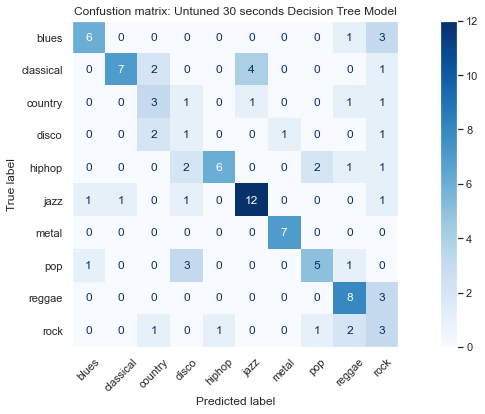

Accuracy : 0.58
Macro F-1 Score : 0.56


In [7]:
# Evaluate Model on Test set
class_labels = list(model_dt.classes_)
macro_f1, accuracy = evaluate_model(predsTestdt, y_test, class_labels, 'Confustion matrix: Untuned 30 seconds Decision Tree Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

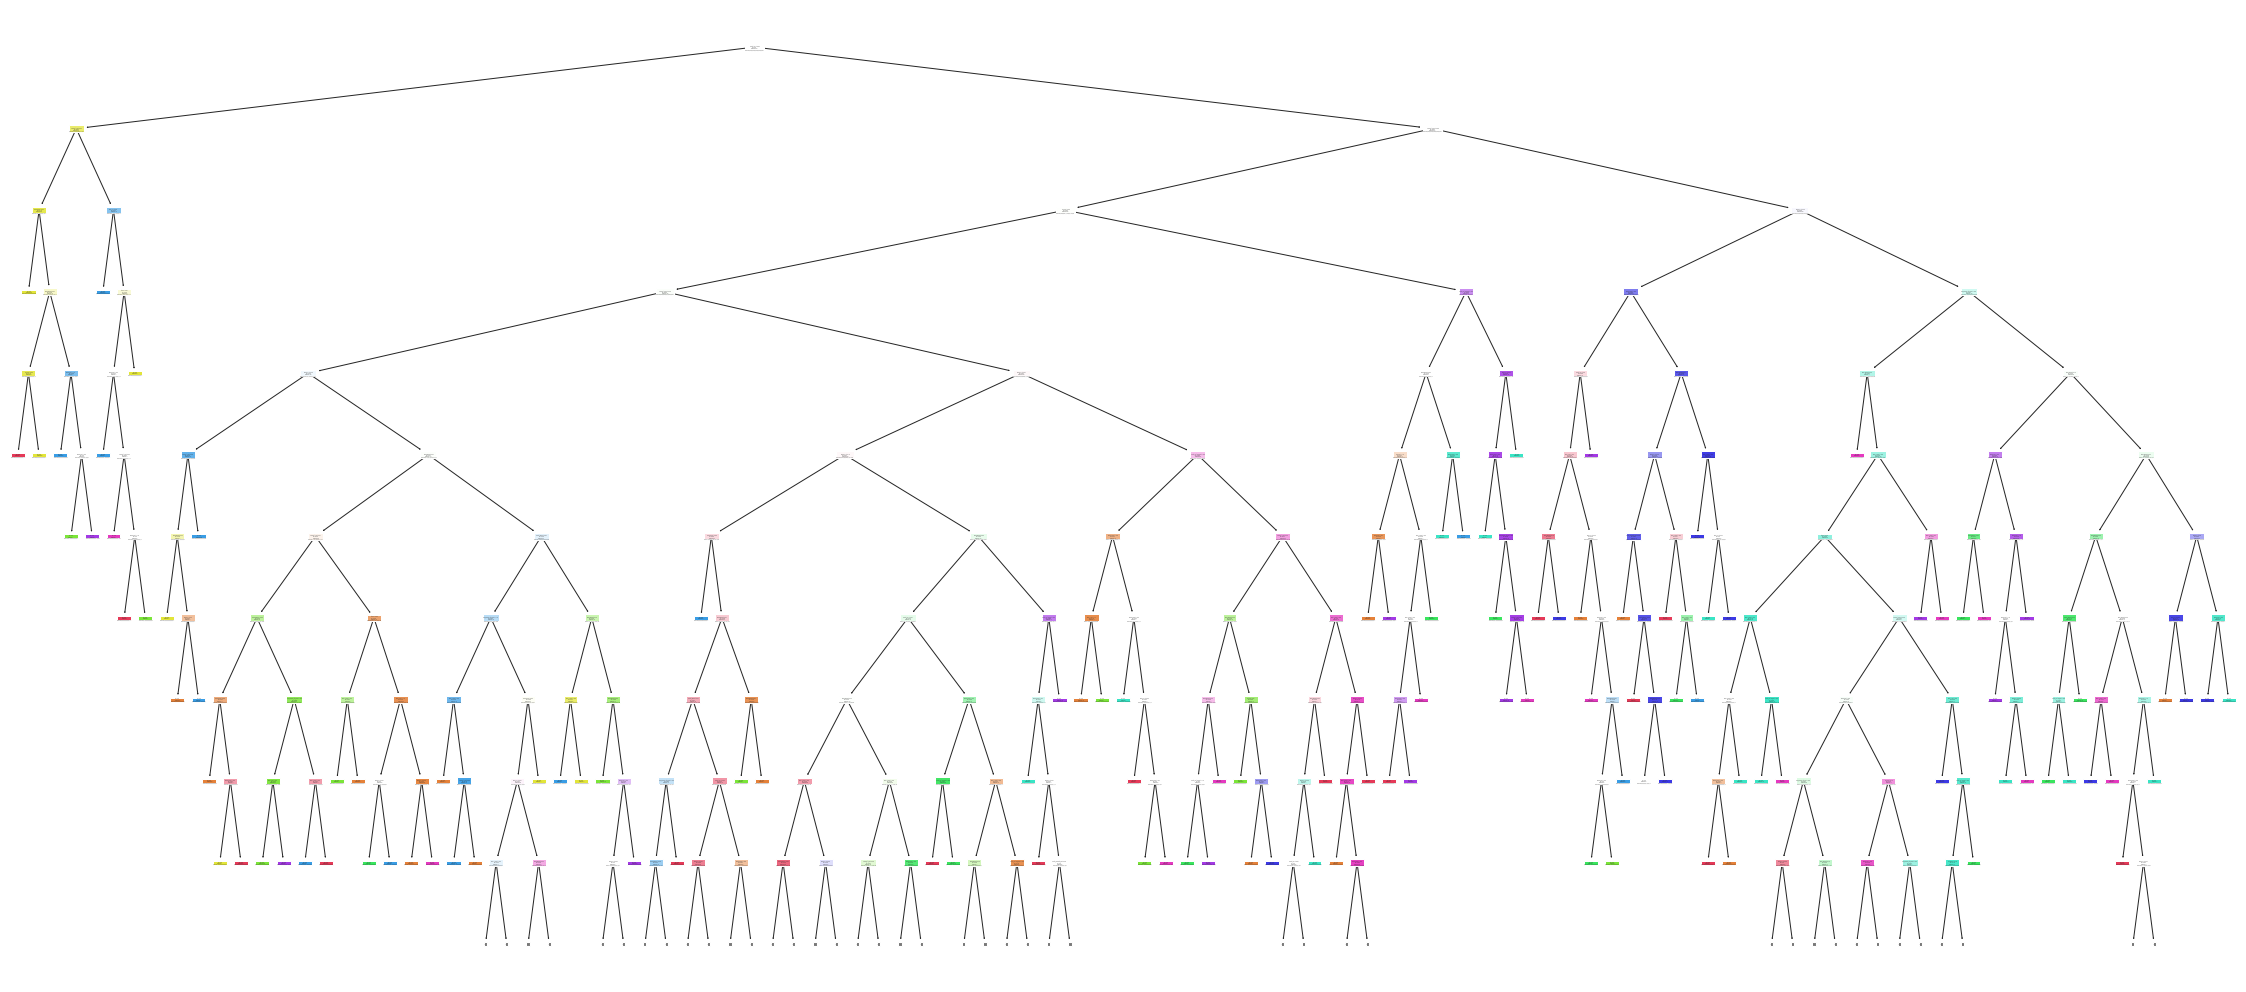

In [8]:
from sklearn import tree 
from sklearn.tree import plot_tree

dev_cols = X_dev.columns.to_list()
fig = plt.figure(figsize=(40,18))
_ = tree.plot_tree(model_dt,max_depth=10,feature_names=dev_cols,filled = True);
plt.savefig('decisiontree_unpruned.png')

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [9]:
print("Max Depth:",model_dt.max_depth)

Max Depth: None


In [10]:
path = model_dt.cost_complexity_pruning_path(X_dev, y_dev)
alphas, impurities = path.ccp_alphas, path.impurities
alphas = alphas[-10:] ###taking last 10 alpha cuz it was taking too much time to train
print(alphas)

[0.01162291 0.01283101 0.01351949 0.0146636  0.01689218 0.0180107
 0.02756663 0.03845301 0.03990636 0.06279123]


In [11]:
model_dt_alpha = []
for i in alphas:
    model_dt1 = DecisionTreeClassifier(random_state=0,ccp_alpha=i)
    model_dt1.fit(X_dev,y_dev)
    model_dt_alpha.append(model_dt1)

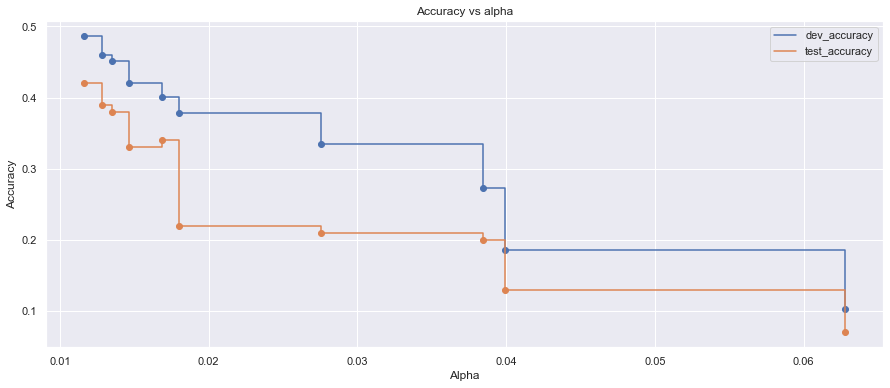

In [12]:
dev_acc = []
test_acc = []
for i in model_dt_alpha:
    y_dev_pred = i.predict(X_dev)
    y_test_pred = i.predict(X_test)
    dev_acc.append(accuracy_score(y_dev, y_dev_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))
    
plt.scatter(alphas,dev_acc)
plt.scatter(alphas,test_acc)
plt.plot(alphas,dev_acc,label='dev_accuracy',drawstyle="steps-post")
plt.plot(alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs alpha')
plt.show()

In [13]:
###cite : https://www.kaggle.com/arunmohan003/pruning-decision-trees-tutorial

best_alpha_dt = DecisionTreeClassifier(ccp_alpha=0.01)
best_alpha_dt.fit(X_dev,y_dev)
y_pruned_dev = best_alpha_dt.predict(X_dev)
y_pruned_test = best_alpha_dt.predict(X_test)

In [14]:
test_score_pruned =  accuracy_score(y_test, y_pruned_test)
dev_score_pruned = accuracy_score(y_dev, y_pruned_dev)

In [15]:
print("Classification Score for Pruned DT on Dev dataset:\n")
print("Dev Score : ", dev_score_pruned)
print(classification_report(y_dev, y_pruned_dev))
print("--------------------------------------------------------")
print("Classification Score for Pruned DT on Test dataset:\n")
print("Test Score :", test_score_pruned)
print(classification_report(y_test, y_pruned_test))

Classification Score for Pruned DT on Dev dataset:

Dev Score :  0.5488888888888889
              precision    recall  f1-score   support

       blues       0.60      0.40      0.48        92
   classical       0.90      0.78      0.84        92
     country       0.85      0.25      0.39        92
       disco       0.59      0.22      0.32        92
      hiphop       0.52      0.62      0.57        93
        jazz       0.52      0.69      0.59        83
       metal       0.80      0.84      0.82        92
         pop       0.81      0.63      0.71        92
      reggae       0.46      0.37      0.41        86
        rock       0.25      0.70      0.37        86

    accuracy                           0.55       900
   macro avg       0.63      0.55      0.55       900
weighted avg       0.63      0.55      0.55       900

--------------------------------------------------------
Classification Score for Pruned DT on Test dataset:

Test Score : 0.51
              precision    re

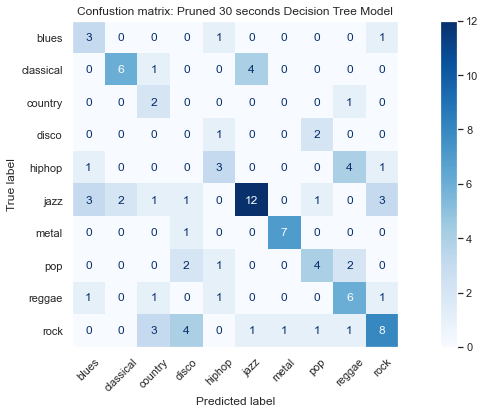

Accuracy : 0.51
Macro F-1 Score : 0.48


In [16]:
# Evaluate Model on Test set
class_labels = list(best_alpha_dt.classes_)
macro_f1, accuracy = evaluate_model(y_pruned_test, y_test, class_labels, 'Confustion matrix: Pruned 30 seconds Decision Tree Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

In [17]:
parameters = {
    'max_depth': np.arange(4, 16, 2, dtype=int),
    'min_samples_leaf': np.linspace(5,100,5,dtype=int),
    'criterion': ["gini", "entropy"]
}

print(parameters)

{'max_depth': array([ 4,  6,  8, 10, 12, 14]), 'min_samples_leaf': array([  5,  28,  52,  76, 100]), 'criterion': ['gini', 'entropy']}


In [18]:
tune_dt = GridSearchCV(estimator = best_alpha_dt, param_grid = parameters, cv = 5)
tune_dt.fit(X_dev, y_dev)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(ccp_alpha=0.01),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 4,  6,  8, 10, 12, 14]),
                         'min_samples_leaf': array([  5,  28,  52,  76, 100])})

In [19]:
print("Best Score :", tune_dt.best_score_)
print("Best Parameters :",tune_dt.best_params_)

Best Score : 0.5166666666666666
Best Parameters : {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 5}


In [20]:
predsDevdt_tuned = tune_dt.predict(X_dev)
predsTestdt_tuned = tune_dt.predict(X_test)

print("Score on Dev data for DT using GridSearchCV:", accuracy_score(y_dev, predsDevdt_tuned))
print("Score on Test data for DT using GridSearchCV:",accuracy_score(y_test, predsTestdt_tuned))

Score on Dev data for DT using GridSearchCV: 0.7911111111111111
Score on Test data for DT using GridSearchCV: 0.58


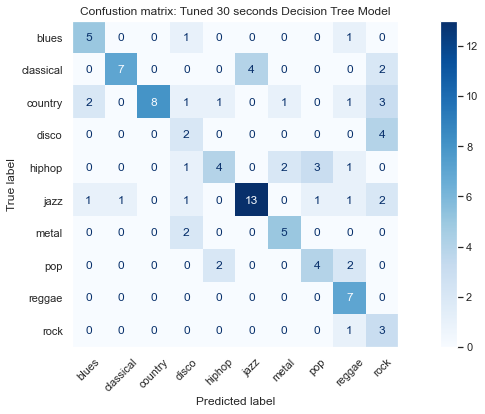

Accuracy : 0.58
Macro F-1 Score : 0.56


In [21]:
# Evaluate Model on Test set
class_labels = list(model_dt.classes_)
macro_f1, accuracy = evaluate_model(predsTestdt_tuned, y_test, class_labels, 'Confustion matrix: Tuned 30 seconds Decision Tree Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

In [22]:
## Plot top 3 Important Features of tuned model

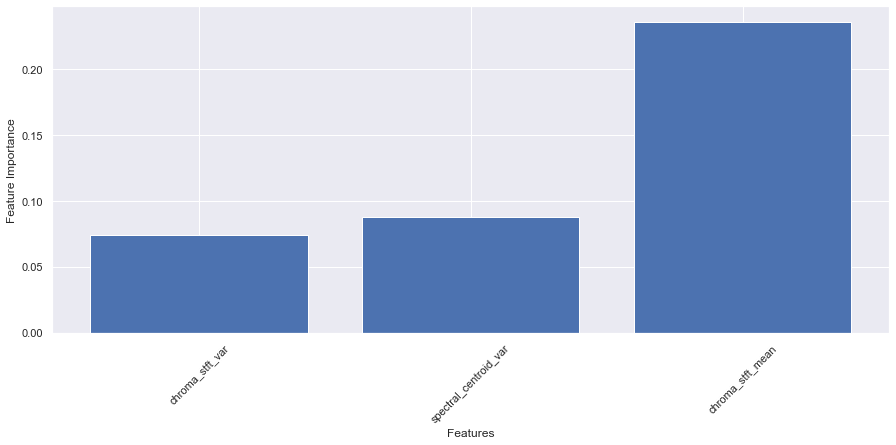

In [23]:
feature_imp_dt = tune_dt.best_estimator_.feature_importances_
final_list_dt = zip(feature_imp_dt,X_dev.columns)
res_dt = sorted(final_list_dt, key = lambda x: x[0])
res_dt = res_dt[-3:]

plt.bar(range(len(res_dt)),[val[0] for val in res_dt],align='center')
plt.xticks(range(len(res_dt)),[val[1] for val in res_dt])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.show()

### Dimensionality reduction of data using PCA

In [24]:
# Principal Component Analysis 
### cite : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

# create the PCA instance
pca = PCA(n_components=30)
# fit on data
pca_data = pca.fit_transform(X_dev)
pca_data_test = pca.transform(X_test)
# pca_data_dev = pca.transform(X_dev)
PCA_df= pd.DataFrame(data=pca_data)
y_dev.index = PCA_df.index
pca_final=pd.concat([PCA_df,y_dev], axis = 1)
# access values
print("Explained Variance of each component:",pca.explained_variance_)
print("Sum of Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance of each component: [0.27462107 0.16378828 0.106374   0.0723295  0.05484226 0.0387792
 0.02690359 0.02395643 0.02175637 0.01846612 0.01427943 0.01395746
 0.01202789 0.01112261 0.01017838 0.00968101 0.00884269 0.00796848
 0.00769712 0.00724503 0.00710401 0.00655176 0.00600085 0.00568628
 0.00541387 0.00490746 0.00484066 0.00467808 0.00445925 0.00421416]
Sum of Explained Variance: 0.9525257442827098


In [25]:
pca_final.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,0.000578,-0.630373,-0.054837,0.410234,0.009388,0.027372,-0.032693,-0.147327,0.031382,0.111809,...,0.076825,0.103306,-0.080101,0.037870,0.001315,-0.022197,0.119701,-0.055219,0.038044,classical
1,0.071451,-0.402465,-0.106786,0.332658,-0.060422,0.226589,0.122802,-0.066843,0.069257,-0.088953,...,0.119533,0.093263,-0.017786,0.095088,-0.013701,-0.110517,-0.024117,0.015213,0.000393,jazz
2,-0.047268,0.326820,-0.598692,0.227380,0.045610,0.264122,-0.077910,0.063576,-0.168400,0.038894,...,-0.087392,0.044747,-0.058709,-0.030530,0.049410,0.075920,-0.028052,-0.154051,-0.049513,country
3,-0.437642,0.235405,-0.003960,0.029110,-0.170677,-0.094825,-0.142896,0.105725,0.099778,-0.181437,...,0.021363,-0.013400,0.028367,0.055805,0.154399,0.073838,0.082496,-0.025944,0.066435,metal
4,-0.849344,0.103658,-0.048105,-0.018132,-0.023246,-0.159358,0.035769,-0.071894,0.111848,0.102866,...,0.040682,-0.010379,0.016745,-0.030134,0.035523,0.003574,-0.040566,0.013195,0.024647,disco


### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [26]:
model_pca = model_dt
model_pca.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTraindt = model_pca.predict(pca_data)
pcaTestdt = model_pca.predict(pca_data_test)

In [27]:
pcatestdt_score =  accuracy_score(y_test, pcaTestdt)
pcadt_score = accuracy_score(y_dev, pcaTraindt)

In [28]:
print("Classification Score for Decision Tree on Train dataset:\n")
print("Train Score : ", pcadt_score)
print("--------------------------------------------------------")
print("Classification Score for Decision Tree on Test dataset:\n")
print("Test Score :", pcatestdt_score)

Classification Score for Decision Tree on Train dataset:

Train Score :  0.9988888888888889
--------------------------------------------------------
Classification Score for Decision Tree on Test dataset:

Test Score : 0.46


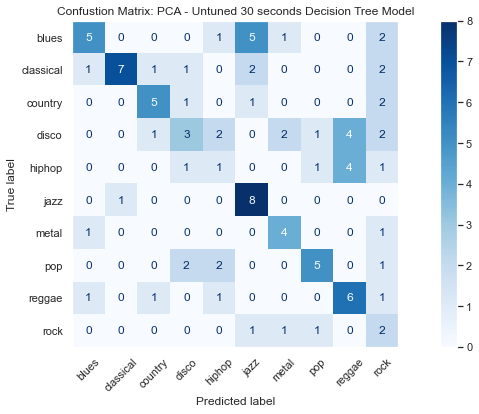

Accuracy : 0.46
Macro F-1 Score : 0.45


In [29]:
# Evaluate Model
class_labels = list(model_pca.classes_)
macro_f1, accuracy = evaluate_model(pcaTestdt, y_test, class_labels, 'Confustion Matrix: PCA - Untuned 30 seconds Decision Tree Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [30]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000578,-0.630373,-0.054837,0.410234,0.009388,0.027372,-0.032693,-0.147327,0.031382,0.111809,...,-0.184705,0.076825,0.103306,-0.080101,0.037870,0.001315,-0.022197,0.119701,-0.055219,0.038044
1,0.071451,-0.402465,-0.106786,0.332658,-0.060422,0.226589,0.122802,-0.066843,0.069257,-0.088953,...,0.119968,0.119533,0.093263,-0.017786,0.095088,-0.013701,-0.110517,-0.024117,0.015213,0.000393
2,-0.047268,0.326820,-0.598692,0.227380,0.045610,0.264122,-0.077910,0.063576,-0.168400,0.038894,...,-0.008935,-0.087392,0.044747,-0.058709,-0.030530,0.049410,0.075920,-0.028052,-0.154051,-0.049513
3,-0.437642,0.235405,-0.003960,0.029110,-0.170677,-0.094825,-0.142896,0.105725,0.099778,-0.181437,...,-0.128682,0.021363,-0.013400,0.028367,0.055805,0.154399,0.073838,0.082496,-0.025944,0.066435
4,-0.849344,0.103658,-0.048105,-0.018132,-0.023246,-0.159358,0.035769,-0.071894,0.111848,0.102866,...,-0.058983,0.040682,-0.010379,0.016745,-0.030134,0.035523,0.003574,-0.040566,0.013195,0.024647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,-0.654431,0.218151,0.332880,0.090825,0.133881,-0.215552,0.054110,0.024764,0.233051,-0.024786,...,0.274156,-0.020250,0.087674,-0.030953,-0.047538,-0.022439,-0.084158,0.001278,0.001878,0.010898
896,0.515280,-0.634698,0.082394,0.485203,-0.101831,-0.139825,-0.145411,0.177612,0.022328,0.179456,...,0.031115,-0.018810,-0.011269,-0.113386,-0.060852,-0.221913,0.040330,0.013242,-0.020444,-0.033518
897,0.976786,0.902560,0.595924,0.289104,0.483065,0.202644,0.115372,0.003237,-0.108642,-0.320613,...,0.044135,0.007880,-0.009881,-0.016957,-0.033381,-0.120603,-0.014307,-0.004219,-0.091291,0.054055
898,0.124804,0.297352,-0.452053,-0.032074,0.037626,0.157138,-0.016196,-0.012237,-0.084173,0.132878,...,0.118977,-0.042675,0.005395,0.028773,0.038036,-0.093408,0.099404,0.033931,-0.042583,-0.079699


In [31]:
model_pca_tuned = tune_dt
model_pca_tuned.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTraindt_tuned = model_pca_tuned.predict(pca_data)
pcaTestdt_tuned = model_pca_tuned.predict(pca_data_test)

In [32]:
pcatestdt_score =  accuracy_score(y_test, pcaTestdt_tuned)
pcadt_score = accuracy_score(y_dev, pcaTraindt_tuned)

In [33]:
print("Classification Score for Decision Tree on Train dataset:\n")
print("Train Score : ", pcadt_score)
print("--------------------------------------------------------")
print("Classification Score for Decision Tree on Test dataset:\n")
print("Test Score :", pcatestdt_score)

Classification Score for Decision Tree on Train dataset:

Train Score :  0.7566666666666667
--------------------------------------------------------
Classification Score for Decision Tree on Test dataset:

Test Score : 0.44


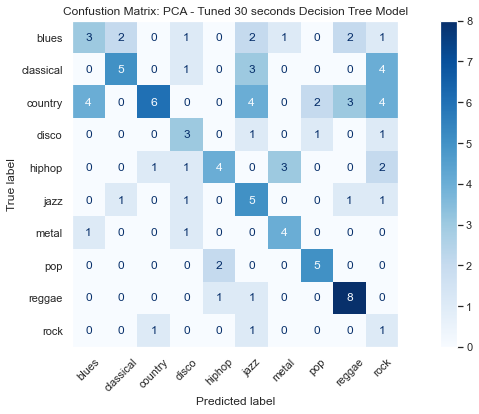

Accuracy : 0.44
Macro F-1 Score : 0.44


In [34]:
# Evaluate Model
class_labels = list(model_pca_tuned.classes_)
macro_f1, accuracy = evaluate_model(pcaTestdt_tuned, y_test, class_labels, 'Confustion Matrix: PCA - Tuned 30 seconds Decision Tree Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)